In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
import os
import sys
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import ogb
import ast

In [56]:
pd.set_option('display.max_rows', 100)

In [57]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader

In [58]:
cwd = os.getcwd()
print(cwd)
cwd_parent = os.path.abspath(os.path.join(cwd, os.pardir))
# cwd_parent = os.path.abspath(os.path.join(cwd, '../../'))
print(cwd_parent)

sys.path.append(cwd_parent)

/Users/aliciapliego/Projects/drug_synergy/AI-predict/code
/Users/aliciapliego/Projects/drug_synergy/AI-predict


In [59]:
import deepadr
from deepadr.dataset import *
from deepadr.utilities import *
from deepadr.chemfeatures import *
from deepadr.train_functions_flat import *
from deepadr.model_gnn_ogb import GNN, DeepAdr_SiameseTrf, ExpressionNN

In [60]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [61]:
from sklearn.preprocessing import StandardScaler

In [62]:
rawdata_dir = '../data/raw/'
processed_dir = '../data/processed/'
up_dir = '..'

In [63]:
report_available_cuda_devices()

no GPU devices available!!


In [64]:
n_gpu = torch.cuda.device_count()
n_gpu

0

In [65]:
fdtype = torch.float32

In [66]:
print("torch:", torch.__version__)
print("CUDA:", torch.version.cuda)

torch: 1.13.1
CUDA: None


### Preparing dataset 

In [67]:
df_drugcomb = pd.read_csv(f'../data/processed/drugcomb_filtered.csv')
df_drugcomb

,cell_line_name,Cell_ID,Drug1_ID,Drug2_ID,ic50_row,ic50_col,ri_row,ri_col,css_row,css_col,css_ri,S_sum,S_mean,S_max,synergy_zip,synergy_loewe,synergy_hsa,synergy_bliss,Drug1,Drug2
0,HCC1419,ACH-000277,AZD5363,MK-2206,0.293095,4.434052e-02,14.945,40.436,42.234,61.899,52.0665,-3.3145,24.3760,11.6305,2.682771,3.267483,6.971932,2.519970,C1CN(CCC1(C(=O)NC(CCO)C2=CC=C(C=C2)Cl)N)C3=NC=...,C1CC(C1)(C2=CC=C(C=C2)C3=C(C=C4C(=N3)C=CN5C4=N...
1,HCC1419,ACH-000277,AZD5363,Perifosine,0.234453,3.839034e-08,11.384,-13.459,13.528,12.411,12.9695,15.0445,14.0070,1.5855,12.457827,-15.518840,-0.439818,12.456200,C1CN(CCC1(C(=O)NC(CCO)C2=CC=C(C=C2)Cl)N)C3=NC=...,CCCCCCCCCCCCCCCCCCOP(=O)([O-])OC1CC[N+](CC1)(C)C
2,HCC1419,ACH-000277,AZD5363,5-azacytidine,0.257603,3.246419e-01,15.858,-8.697,13.535,22.914,18.2245,11.0635,14.6440,2.3665,5.870657,-20.124636,-5.007640,3.287166,C1CN(CCC1(C(=O)NC(CCO)C2=CC=C(C=C2)Cl)N)C3=NC=...,C1=NC(=NC(=O)N1C2C(C(C(O2)CO)O)O)N
3,HCC1419,ACH-000277,AZD5363,803712-79-0,0.284417,1.170122e-01,7.346,41.888,61.267,63.258,62.2625,13.0285,37.6455,20.3745,5.925285,-7.153205,4.876276,6.720925,C1CN(CCC1(C(=O)NC(CCO)C2=CC=C(C=C2)Cl)N)C3=NC=...,CC1=CC(=C(N1)C=C2C(=CC(=C3C=C4C=CC=CC4=N3)N2)O...
4,HCC1419,ACH-000277,AZD5363,Navitoclax,0.282129,3.019878e-01,7.060,1.376,41.825,41.708,41.7665,33.3305,37.5485,34.7065,13.331041,7.214639,12.788118,20.048099,C1CN(CCC1(C(=O)NC(CCO)C2=CC=C(C=C2)Cl)N)C3=NC=...,CC1(CCC(=C(C1)CN2CCN(CC2)C3=CC=C(C=C3)C(=O)NS(...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233531,DMS 114,ACH-000530,503468-95-9,HG-14-10-04,1.082188,3.000000e+00,5.261,41.753,90.433,58.802,74.6175,27.6035,51.1105,32.8645,6.487383,2.211128,10.646970,7.656814,C1COCCN1C2=CC(=O)C3=C(O2)C(=CC=C3)C4=CC=CC5=C4...,CN1CCN(CC1)C2CCN(CC2)C3=CC(=C(C=C3)NC4=NC=C(C(...
233532,DMS 114,ACH-000530,503468-95-9,NSC169534,3.000000,2.751665e-02,11.199,27.671,61.071,71.177,66.1240,27.2540,46.6890,38.4530,7.666412,11.413245,13.771694,9.142595,C1COCCN1C2=CC(=O)C3=C(O2)C(=CC=C3)C4=CC=CC5=C4...,CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C...
233533,DMS 114,ACH-000530,503468-95-9,33419-42-0,3.000000,6.038796e-01,14.136,36.976,65.635,75.917,70.7760,19.6640,45.2200,33.8000,8.622407,11.454024,13.895436,8.296740,C1COCCN1C2=CC(=O)C3=C(O2)C(=CC=C3)C4=CC=CC5=C4...,CC1OCC2C(O1)C(C(C(O2)OC3C4COC(=O)C4C(C5=CC6=C(...
233534,DMS 114,ACH-000530,topotecan,AZ13453202,0.100000,3.000000e+00,23.109,7.749,28.545,92.023,60.2840,29.4260,44.8550,37.1750,-2.933191,-57.799673,1.207848,-2.553007,CCC1(C2=C(COC1=O)C(=O)N3CC4=C(C3=C2)N=C5C=CC(=...,CN(C)CC#Cc1ccc(OCCCc2sc(nc2C(=O)O)N3CCc4cccc(C...


In [68]:
df_rna = pd.read_csv('../data/processed/gene_expression_data_preprocessed.csv')
df_rna

,Gene_ID,ACH-000277,ACH-000837,ACH-000930,ACH-000615,ACH-000090,ACH-000147,ACH-000849,ACH-000785,ACH-001190,...,ACH-000551,ACH-000720,ACH-001196,ACH-000376,ACH-000267,ACH-000680,ACH-000481,ACH-000856,ACH-000730,ACH-000530
0,1,5.146492,2.981853,4.052242,4.822220,1.263034,4.516646,2.678072,0.847997,3.893362,...,4.624686,0.695994,2.010780,4.305971,4.175525,0.250962,0.704872,4.724105,4.174726,5.621759
1,10,0.124328,0.286881,0.000000,0.000000,0.042644,0.250962,0.163499,0.485427,0.111031,...,0.000000,0.137504,0.464668,0.250962,0.000000,1.807355,0.163499,0.070389,0.056584,0.000000
2,100,0.084064,3.481557,4.149747,2.639232,2.891419,1.726831,3.559492,4.827819,3.538538,...,2.899176,2.017922,5.140370,2.912650,2.147307,3.635754,2.780310,3.970854,3.975447,3.565597
3,1000,0.238787,2.881665,0.622930,3.273516,5.226123,0.056584,1.803227,0.042644,0.910733,...,0.189034,6.029232,0.014355,5.497932,0.356144,0.042644,4.279471,3.085765,0.411426,0.464668
4,10000,0.070389,4.249445,5.250583,4.321207,3.171527,0.111031,3.727920,0.150560,4.725196,...,0.536053,4.532317,3.763412,2.847997,4.167519,0.097611,1.739848,0.855990,3.790772,4.123501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19174,9991,5.309613,4.902556,4.092546,3.760221,3.324811,4.984134,5.244887,5.058316,4.819668,...,5.868637,4.264536,5.034304,4.020591,5.584662,5.960697,4.760753,4.704872,4.377124,4.574707
19175,9992,0.695994,0.176323,0.613532,0.056584,0.189034,0.575312,0.978196,0.226509,0.000000,...,0.070389,0.263034,0.000000,0.250962,1.014355,0.014355,0.084064,0.286881,0.000000,0.263034
19176,9993,5.157044,5.458448,6.129077,5.028569,3.657640,4.785027,5.043957,4.965323,4.438293,...,5.864929,5.216455,4.590961,5.011675,4.121844,4.756490,4.759688,5.978424,4.508429,5.271276
19177,9994,3.590961,3.317594,2.744161,3.139142,2.260026,3.215679,4.186659,2.480265,3.584963,...,3.671293,3.467279,3.544733,3.157044,4.303781,3.187451,3.196922,4.286142,2.671293,4.100978


In [69]:
df_cnv = pd.read_csv('../data/processed/cnv_data_preprocessed.csv')
df_cnv

,Gene_ID,ACH-000277,ACH-000837,ACH-000930,ACH-000615,ACH-000090,ACH-000147,ACH-000849,ACH-000785,ACH-001190,...,ACH-000551,ACH-000720,ACH-001196,ACH-000376,ACH-000267,ACH-000680,ACH-000481,ACH-000856,ACH-000730,ACH-000530
0,1,1.031555,0.944715,0.756541,1.206992,1.211438,0.768499,1.341251,1.452116,0.905456,...,1.002602,0.925300,1.029293,1.096465,1.008494,0.741872,1.354908,0.980352,0.806532,1.173974
1,10,1.093802,0.546255,0.744336,0.835375,0.784642,0.832593,0.861512,0.640122,0.977407,...,0.982000,0.915472,1.469678,1.037913,0.574689,1.076897,1.076598,1.024159,0.747238,0.707131
2,100,1.787550,1.471560,2.021517,0.925605,1.251417,1.356372,1.037354,1.222511,1.282751,...,1.003322,1.122776,1.075256,1.021755,0.580835,1.416126,1.345187,1.042199,1.296084,0.834743
3,1000,0.685398,0.922892,1.081175,0.817158,1.130757,0.858228,0.818851,0.386752,0.974166,...,1.172393,0.808366,1.165846,1.016473,1.003177,0.810428,1.085301,1.038358,0.950280,1.001396
4,10000,1.108415,1.183689,1.529492,0.994248,1.320970,1.125498,1.235262,1.218143,1.092804,...,1.206254,1.197469,0.985526,1.004714,1.011931,1.047703,1.319866,1.014745,1.046404,1.044751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19174,9991,1.380481,0.925425,0.767892,0.898100,0.811080,1.381067,0.869019,0.918873,0.973519,...,0.997630,0.964079,1.302591,1.029486,1.013011,1.333506,0.840148,1.017062,1.110135,0.766850
19175,9992,1.042669,0.933492,1.191881,0.951660,1.238675,1.077861,1.309751,0.919539,0.970371,...,1.193927,0.921105,1.009351,1.230122,1.004917,0.791777,0.804547,0.993864,0.856674,0.972384
19176,9993,1.009506,1.258480,1.235767,1.325867,0.751190,0.769720,1.100519,1.088386,1.275583,...,2.066792,0.975385,1.157416,0.996319,1.036152,0.773341,1.055446,1.002974,1.136541,0.772943
19177,9994,1.129907,0.935139,0.779656,1.126231,0.790715,0.869332,1.453172,0.833466,0.977201,...,0.988313,0.886080,0.780440,0.991999,1.031005,0.971278,0.988014,1.020099,0.909038,0.994358


In [70]:
df_mut = pd.read_csv('../data/processed/mutation_data_preprocessed.csv')
df_mut

,Gene_ID,ACH-000277,ACH-000837,ACH-000930,ACH-000615,ACH-000090,ACH-000147,ACH-000849,ACH-000785,ACH-001190,...,ACH-000551,ACH-000720,ACH-001196,ACH-000376,ACH-000267,ACH-000680,ACH-000481,ACH-000856,ACH-000730,ACH-000530
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1000,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,10000,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19174,9991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19175,9992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19176,9993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19177,9994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
targetdata_dir = create_directory(os.path.join(processed_dir, 'dataset_generation'))
targetdata_dir_raw = create_directory(os.path.join(targetdata_dir, "raw"))
targetdata_dir_processed = create_directory(os.path.join(targetdata_dir, "processed"))


path_current_dir /Users/aliciapliego/Projects/drug_synergy/AI-predict/deepadr
path_current_dir /Users/aliciapliego/Projects/drug_synergy/AI-predict/deepadr
path_current_dir /Users/aliciapliego/Projects/drug_synergy/AI-predict/deepadr


In [72]:
#targetdata_dir = create_directory(os.path.join(processed_dir, DSdataset_name, data_fname))
#targetdata_dir_raw = create_directory(os.path.join(targetdata_dir, "raw"))
#targetdata_dir_processed = create_directory(os.path.join(targetdata_dir, "processed"))
##ReaderWriter.dump_data(dpartitions, os.path.join(targetdata_dir, 'data_partitions.pkl'))

In [73]:
targetdata_dir

'/Users/aliciapliego/Projects/drug_synergy/AI-predict/data/processed/dataset_generation'

In [74]:
data = df_drugcomb
data

,cell_line_name,Cell_ID,Drug1_ID,Drug2_ID,ic50_row,ic50_col,ri_row,ri_col,css_row,css_col,css_ri,S_sum,S_mean,S_max,synergy_zip,synergy_loewe,synergy_hsa,synergy_bliss,Drug1,Drug2
0,HCC1419,ACH-000277,AZD5363,MK-2206,0.293095,4.434052e-02,14.945,40.436,42.234,61.899,52.0665,-3.3145,24.3760,11.6305,2.682771,3.267483,6.971932,2.519970,C1CN(CCC1(C(=O)NC(CCO)C2=CC=C(C=C2)Cl)N)C3=NC=...,C1CC(C1)(C2=CC=C(C=C2)C3=C(C=C4C(=N3)C=CN5C4=N...
1,HCC1419,ACH-000277,AZD5363,Perifosine,0.234453,3.839034e-08,11.384,-13.459,13.528,12.411,12.9695,15.0445,14.0070,1.5855,12.457827,-15.518840,-0.439818,12.456200,C1CN(CCC1(C(=O)NC(CCO)C2=CC=C(C=C2)Cl)N)C3=NC=...,CCCCCCCCCCCCCCCCCCOP(=O)([O-])OC1CC[N+](CC1)(C)C
2,HCC1419,ACH-000277,AZD5363,5-azacytidine,0.257603,3.246419e-01,15.858,-8.697,13.535,22.914,18.2245,11.0635,14.6440,2.3665,5.870657,-20.124636,-5.007640,3.287166,C1CN(CCC1(C(=O)NC(CCO)C2=CC=C(C=C2)Cl)N)C3=NC=...,C1=NC(=NC(=O)N1C2C(C(C(O2)CO)O)O)N
3,HCC1419,ACH-000277,AZD5363,803712-79-0,0.284417,1.170122e-01,7.346,41.888,61.267,63.258,62.2625,13.0285,37.6455,20.3745,5.925285,-7.153205,4.876276,6.720925,C1CN(CCC1(C(=O)NC(CCO)C2=CC=C(C=C2)Cl)N)C3=NC=...,CC1=CC(=C(N1)C=C2C(=CC(=C3C=C4C=CC=CC4=N3)N2)O...
4,HCC1419,ACH-000277,AZD5363,Navitoclax,0.282129,3.019878e-01,7.060,1.376,41.825,41.708,41.7665,33.3305,37.5485,34.7065,13.331041,7.214639,12.788118,20.048099,C1CN(CCC1(C(=O)NC(CCO)C2=CC=C(C=C2)Cl)N)C3=NC=...,CC1(CCC(=C(C1)CN2CCN(CC2)C3=CC=C(C=C3)C(=O)NS(...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233531,DMS 114,ACH-000530,503468-95-9,HG-14-10-04,1.082188,3.000000e+00,5.261,41.753,90.433,58.802,74.6175,27.6035,51.1105,32.8645,6.487383,2.211128,10.646970,7.656814,C1COCCN1C2=CC(=O)C3=C(O2)C(=CC=C3)C4=CC=CC5=C4...,CN1CCN(CC1)C2CCN(CC2)C3=CC(=C(C=C3)NC4=NC=C(C(...
233532,DMS 114,ACH-000530,503468-95-9,NSC169534,3.000000,2.751665e-02,11.199,27.671,61.071,71.177,66.1240,27.2540,46.6890,38.4530,7.666412,11.413245,13.771694,9.142595,C1COCCN1C2=CC(=O)C3=C(O2)C(=CC=C3)C4=CC=CC5=C4...,CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C...
233533,DMS 114,ACH-000530,503468-95-9,33419-42-0,3.000000,6.038796e-01,14.136,36.976,65.635,75.917,70.7760,19.6640,45.2200,33.8000,8.622407,11.454024,13.895436,8.296740,C1COCCN1C2=CC(=O)C3=C(O2)C(=CC=C3)C4=CC=CC5=C4...,CC1OCC2C(O1)C(C(C(O2)OC3C4COC(=O)C4C(C5=CC6=C(...
233534,DMS 114,ACH-000530,topotecan,AZ13453202,0.100000,3.000000e+00,23.109,7.749,28.545,92.023,60.2840,29.4260,44.8550,37.1750,-2.933191,-57.799673,1.207848,-2.553007,CCC1(C2=C(COC1=O)C(=O)N3CC4=C(C3=C2)N=C5C=CC(=...,CN(C)CC#Cc1ccc(OCCCc2sc(nc2C(=O)O)N3CCc4cccc(C...


In [75]:
data = data.drop(index=data[(data.Drug1.str.contains("Antibody")) | (data.Drug2.str.contains("Antibody"))].index)
data.index = range(len(data))
len(data)

233326

In [76]:
uniq_data = ddi_dataframe_to_unique_drugs(data)
uniq_data

,Drug_ID,Drug
0,AZD5363,C1CN(CCC1(C(=O)NC(CCO)C2=CC=C(C=C2)Cl)N)C3=NC=...
1,AZ13453202,CN(C)CC#Cc1ccc(OCCCc2sc(nc2C(=O)O)N3CCc4cccc(C...
2,AZ12419304,CC1=C(C=C(C=C1)C(=O)NC2=CC(=NC=C2)C(F)(F)F)NC3...
3,41575-94-4,C1CC(C1)(C(=O)O)C(=O)O.[NH2-].[NH2-].[Pt+2]
4,Carboplatin Paclitaxel,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...
...,...,...
3110,CHEMBL2325704,CS(=O)(=O)C1(CC1)C2=CC(=NC(=N2)C3=C4C=CNC4=CC=...
3111,SCHEMBL1559365,CC1=NN(C=C1NC2=NC=C(C(=C2)NC3=C(C=C(C=C3)F)C(=...
3112,SCHEMBL1557791,CC1=NN(C=C1NC2=NC=C(C(=C2)NC3=CC=CC=C3C(=O)NC)...
3113,BAY 65-1942,C1CC(CNC1)C2=CC(=NC3=C2COC(=O)N3)C4=C(C=CC=C4O...


In [77]:
uniq_data.Drug = [d.split("; ")[1] if ("; " in d) else d for d in uniq_data.Drug]
uniq_data.Drug = [d.split(";")[1] if (";" in d) else d for d in uniq_data.Drug]

In [78]:
uniq_data['Mol'] = [smiles_to_mol(smiles) for smiles in uniq_data.Drug]

In [79]:
uniq_mol = uniq_data[~uniq_data.Mol.isnull()]
uniq_mol['DataOGB'] = [smiles_to_graph_data_obj_ogb(smiles) for smiles in uniq_mol.Drug]
uniq_mol = uniq_mol.set_index("Drug_ID")
uniq_mol

,Drug,Mol,DataOGB
Drug_ID,,,
AZD5363,C1CN(CCC1(C(=O)NC(CCO)C2=CC=C(C=C2)Cl)N)C3=NC=...,<rdkit.Chem.rdchem.Mol object at 0x154c400b0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
AZ13453202,CN(C)CC#Cc1ccc(cc1)OCCCc2c(nc(s2)N3CCc4cccc(c4...,<rdkit.Chem.rdchem.Mol object at 0x154c40190>,"[(edge_index, [tensor([ 0, 1, 1, 2, 1, 3,..."
AZ12419304,CC1=C(C=C(C=C1)C(=O)NC2=CC(=NC=C2)C(F)(F)F)NC3...,<rdkit.Chem.rdchem.Mol object at 0x154c40120>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
41575-94-4,C1CC(C1)(C(=O)O)C(=O)O.[NH2-].[NH2-].[Pt+2],<rdkit.Chem.rdchem.Mol object at 0x154c40270>,"[(edge_index, [tensor([0, 1, 1, 2, 2, 3, 2, 4,..."
Carboplatin Paclitaxel,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...,<rdkit.Chem.rdchem.Mol object at 0x154c402e0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
...,...,...,...
CHEMBL2325704,CS(=O)(=O)C1(CC1)C2=CC(=NC(=N2)C3=C4C=CNC4=CC=...,<rdkit.Chem.rdchem.Mol object at 0x154f096d0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 1, 3,..."
SCHEMBL1559365,CC1=NN(C=C1NC2=NC=C(C(=C2)NC3=C(C=C(C=C3)F)C(=...,<rdkit.Chem.rdchem.Mol object at 0x154f09740>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
SCHEMBL1557791,CC1=NN(C=C1NC2=NC=C(C(=C2)NC3=CC=CC=C3C(=O)NC)...,<rdkit.Chem.rdchem.Mol object at 0x154f097b0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."


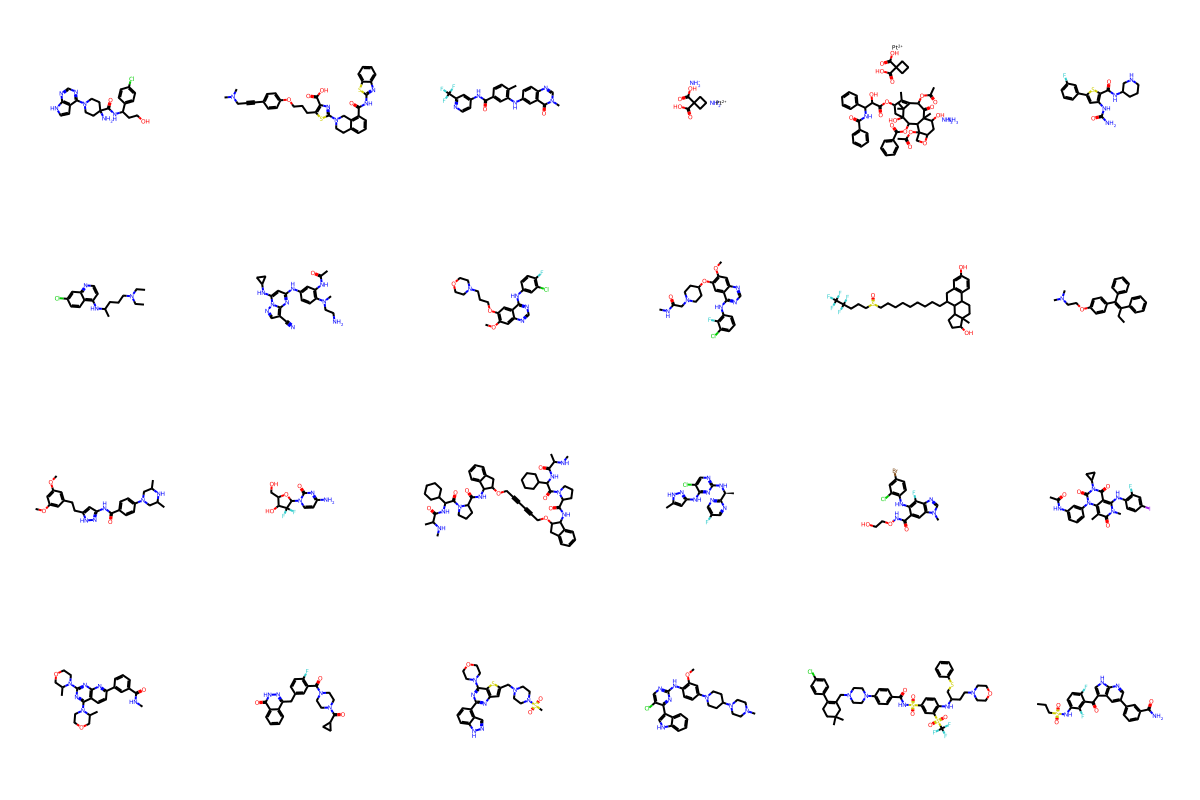

In [80]:
Draw.MolsToGridImage(uniq_mol.Mol.head(24), molsPerRow=6)

In [81]:
uniq_mol.iloc[0].DataOGB

Data(edge_index=[2, 66], edge_attr=[66, 3], x=[30, 9])

In [82]:
#if (data_fname == 'data_v2' or data_fname == 'data_v4'): #baseline model
#    print("generating xFlat for", data_fname)
#    uniq_mol['xFlat'] = [torch.mean(torch.clone(data.x).type(torch.float32), dim=0) for data in uniq_mol['DataOGB']]

In [83]:
#Save values for the synergy scores as an array. Concatenate for every row the four scores

# Create an empty list
scores_list =[]
  
# Iterate over each row
for index, rows in data.iterrows():
    # Create list for the current row
    list_scores =[rows.synergy_zip, rows.synergy_loewe, rows.synergy_hsa, rows.synergy_bliss]
      
    # append the list to the final list
    scores_list.append(list_scores)
  
# Print the list
print(scores_list)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [31]:
synergy_scores = np.array(scores_list)

In [32]:
len(synergy_scores)

233326

In [33]:
synergy_scores

array([[  2.68277073,   3.26748335,   6.9719321 ,   2.51996961],
       [ 12.45782697, -15.51884021,  -0.43981753,  12.45620043],
       [  5.87065687, -20.12463556,  -5.00763983,   3.2871655 ],
       ...,
       [  8.62240688,  11.45402374,  13.89543623,   8.29674041],
       [ -2.93319093, -57.79967307,   1.20784834,  -2.55300746],
       [  0.46435385, -53.61630743,   4.08378245,  -1.2646384 ]])

In [34]:
ReaderWriter.dump_data(synergy_scores, os.path.join(targetdata_dir_raw, 'y.pkl'))

In [35]:
data.to_csv(os.path.join(targetdata_dir_raw, 'data_pkl.tsv'), sep = '\t')

In [90]:
# Filter 900 random genes:
df_rna_rnd =  df_rna.head(100)
df_rna_rnd_array = np.array([df_rna_rnd[str(c)].values for c in data["Cell_ID"]])
df_rna_rnd_array.shape

(233326, 100)

In [36]:
rna_array = np.array([df_rna[str(c)].values for c in data["Cell_ID"]])
rna_array.shape

(233326, 19179)

In [91]:
ReaderWriter.dump_data(df_rna_rnd_array, os.path.join(targetdata_dir_raw, 'expression_900_rnd.pkl'))

In [37]:
ReaderWriter.dump_data(rna_array, os.path.join(targetdata_dir_raw, 'expression.pkl'))

In [44]:
cnv_array = np.array([df_cnv[str(c)].values for c in data["Cell_ID"]])
cnv_array.shape

(233326, 19179)

In [45]:
mut_array = np.array([df_mut[str(c)].values for c in data["Cell_ID"]])
mut_array.shape

(233326, 19179)

In [ ]:
len(mut_array)

In [ ]:
omics_array = np.array([mut_array,cnv_array, rna_array])

In [ ]:
#omics_array = np.array([omics[str(c)].values for c in data["Cell_ID"]])
#omics_array.shape

In [ ]:
ReaderWriter.dump_data(omics_array, os.path.join(targetdata_dir_raw, 'omics.pkl'))

In [ ]:
#   write pickled data to file
#with open(os.path.join(targetdata_dir_raw, 'omics.pkl'), 'wb') as f:
#    pickle.dump(omics_array, f)


In [ ]:
#ReaderWriter.dump_data(omics_array, os.path.join(targetdata_dir_raw, 'omics.pkl'))

In [ ]:
pairs = {i:(row.Drug1_ID, row.Drug2_ID) for i, row in data.iterrows()}
len(pairs)

In [ ]:
ReaderWriter.dump_data(pairs, os.path.join(targetdata_dir_raw, 'pairs.pkl'))

In [ ]:
ReaderWriter.dump_data(data, os.path.join(targetdata_dir_raw, 'data_pairs.pkl'))

In [ ]:
%%time
X = ReaderWriter.read_or_dump_data(file_name=norm_join_paths(targetdata_dir_raw, 'X.pkl'),
                              data_gen_fun=get_X_all_pairdata_synergy,
                              data_gen_params=(uniq_mol, pairs, "DataOGB"))

In [ ]:
#if (data_fname == 'data_v2' or data_fname == 'data_v4'): #baseline model
#    X = ReaderWriter.read_or_dump_data(file_name=norm_join_paths(targetdata_dir_raw, 'X_flat.pkl'),
#                              data_gen_fun=get_X_all_pairdata_synergy_flat,
#                              data_gen_params=(uniq_mol, pairs, "xFlat"))

In [ ]:
%%time

# In order to generate a new Dataset, first remove the generated files above

dataset = MoleculeDataset(root=targetdata_dir, dataset='tdcSynergy')

In [ ]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

In [ ]:
X = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'X.pkl'))
y = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'y.pkl'))
            